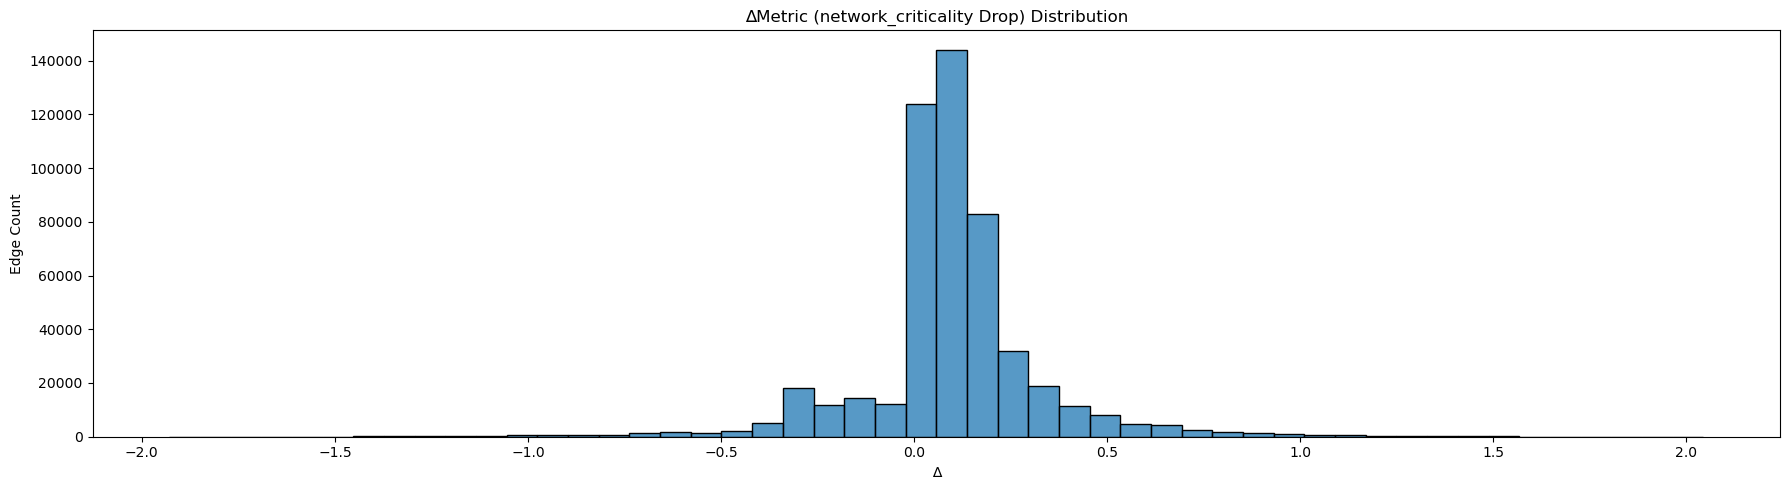

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load dataset (replace with your path)
# metric = "egr"
# metric = "nc3"
metric = "network_criticality"
dataset = torch.load("./criticality_dataset_"+metric+".pt", weights_only=False)

# Optional: limit to first 1000 graphs to avoid memory issues
# dataset = dataset[:1000]

node_counts = []
edge_counts = []
delta_metrics = []

for graph in dataset:
    G = nx.from_graph6_bytes(graph['graph6'].encode())
    node_counts.append(G.number_of_nodes())
    edge_counts.append(G.number_of_edges())
    if 'node_'+metric in graph:
        delta_metrics.extend(graph['node_'+metric])
    if 'edge_'+metric in graph:
        delta_metrics.extend(graph['edge_'+metric])

# Plot histograms
fig, axes = plt.subplots(1, 1, figsize=(18, 5))

# sns.histplot(node_counts, bins=range(min(node_counts), max(node_counts)+2), ax=axes[0], discrete=True)
# axes[0].set_title("Node Count Distribution")
# axes[0].set_xlabel("Number of Nodes")
# axes[0].set_ylabel("Graph Count")

# sns.histplot(edge_counts, bins=20, ax=axes[1])
# axes[1].set_title("Edge Count Distribution")
# axes[1].set_xlabel("Number of Edges")
# axes[1].set_ylabel("Graph Count")

sns.histplot(delta_metrics, bins=50, ax=axes)
axes.set_title("∆Metric ("+metric+" Drop) Distribution")
axes.set_xlabel("∆")
axes.set_ylabel("Edge Count")

plt.tight_layout()
plt.show()


In [2]:
import numpy as np
mean_val = np.mean(delta_metrics)
std_val = np.std(delta_metrics)
delta_metrics_norm = (delta_metrics - mean_val) / std_val
# delta_metrics = np.array(delta_metrics)
# min_val = np.min(delta_metrics)
# max_val = np.max(delta_metrics)
# delta_metrics_norm = (delta_metrics - min_val) / (max_val - min_val)

print(delta_metrics_norm)
delta_transformed = np.sign(delta_metrics_norm) * np.log1p(abs(delta_metrics_norm))
print(delta_transformed)

from copy import deepcopy

# Prati gdje si stao u listi normaliziranih vrijednosti
norm_idx = 0
dataset_norm = deepcopy(dataset)  # Kopija originala da ne prepišeš sve

for graph in dataset_norm:
    num_nodes = len(graph['node_index'])
    num_edges = len(graph['edge_index'])

    # Normaliziraj node metrike
    if 'node_' + metric in graph:
        graph['node_' + metric] = delta_transformed[norm_idx : norm_idx + num_nodes].tolist()
        norm_idx += num_nodes

    # Normaliziraj edge metrike
    if 'edge_' + metric in graph:
        graph['edge_' + metric] = delta_transformed[norm_idx : norm_idx + num_edges].tolist()
        norm_idx += num_edges

torch.save(dataset_norm, "./criticality_dataset_" + metric + "_normalized.pt")


[ 1.0116609   1.0116609   1.0116609  ... -0.04819321 -0.20864922
 -0.13686627]
[ 0.6989607   0.6989607   0.6989607  ... -0.04706793 -0.18950338
 -0.12827559]


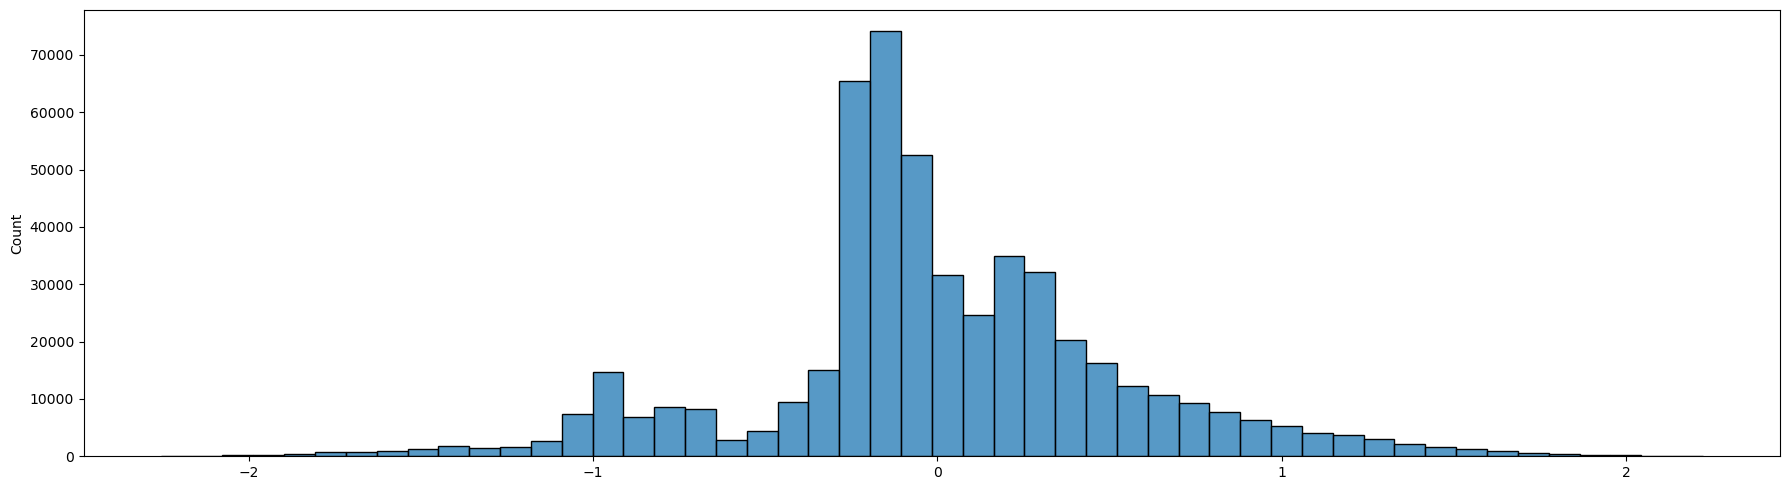

In [3]:
fig, axes = plt.subplots(1, 1, figsize=(18, 5))
sns.histplot(delta_transformed, bins=50, ax=axes)
plt.tight_layout()
plt.show()